In [23]:
'''
Script to run time series models against all data in the \data folder.
Author: @josh
'''
import os
import numpy as np
import pandas as pd
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Dropout, GRU, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

from tensorflow.keras.layers import Input, Dense, Activation,Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error
from math import sqrt


#from fbprophet import Prophet

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')



In [77]:
import custom_series as cs

#cs.getScript('monkey.py', './monkey.py')

import monkey as mk

In [4]:
nbr_epochs = 100

In [5]:


def create_files_dict(pth='./data/'):
    '''
    create dictionary of files
    '''
    # pull all data files
    files = os.listdir(pth)
    print(files)

    all_data = dict()
    for file in files:

        # create key and file path
        file_key = file.split('_')[0]
        file_path = os.path.join(pth, file)

        # read the data
        data = pd.read_csv(
            file_path,
            index_col='Date',
            parse_dates=['Date']
        )

        # store data in dictionary
        all_data[file_key] = data

    return all_data


def plot_data(data, stock_name, pth='./figures/'):
    '''
    plot the data
    '''
    # create train and test
    data["High"][:'2016'].plot(figsize=(16, 4), legend=True)
    data["High"]['2017':].plot(figsize=(16, 4), legend=True)

    # plot the data
    plt.legend(['Training set (Before 2017)', 'Test set (2017 and beyond)'])
    plt.title('{} stock price'.format(stock_name))
    fig_path = os.path.join(pth, stock_name + '_train_test')

    # save the data, pause, and close
    plt.savefig(fig_path)
    plt.pause(1)
    plt.close()


def create_dl_train_test_split(all_data):
    '''
    create training/testing data and scaler object
    '''
    # create training and test set
    training_set = all_data[:'2016'].iloc[:, 1:2].values
    test_set = all_data['2017':].iloc[:, 1:2].values

    # scale the data
    sc = MinMaxScaler(feature_range=(0, 1))
    training_set_scaled = sc.fit_transform(training_set)

    # create training and test data
    X_train = []
    y_train = []
    for i in range(60, 2768):
        X_train.append(training_set_scaled[i - 60:i, 0])
        y_train.append(training_set_scaled[i, 0])

    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    total_data = pd.concat(
        (all_data["High"][:'2016'], all_data["High"]['2017':]), axis=0)
    inputs = total_data[len(total_data) - len(test_set) - 60:].values
    inputs = inputs.reshape(-1, 1)
    inputs = sc.transform(inputs)

    # Preparing X_test
    X_test = []
    for i in range(60, 311):
        X_test.append(inputs[i - 60:i, 0])

    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, sc


def create_single_layer_small_rnn_model(X_train, y_train, X_test, sc):
    '''
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    model = Sequential()
    model.add(SimpleRNN(6))
    model.add(Dense(1))

    model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    model.fit(X_train, y_train, epochs=nbr_epochs, batch_size=150)

    # Finalizing predictions
    scaled_preds = model.predict(X_test)
    test_preds = sc.inverse_transform(scaled_preds)

    return model, test_preds


def create_single_layer_rnn_model(X_train, y_train, X_test, sc):
    '''
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    model = Sequential()
    model.add(SimpleRNN(32))
    model.add(Dense(1))

    model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    model.fit(X_train, y_train, epochs=nbr_epochs, batch_size=150)

    # Finalizing predictions
    scaled_preds = model.predict(X_test)
    test_preds = sc.inverse_transform(scaled_preds)

    return model, test_preds


def create_rnn_model(X_train, y_train, X_test, sc):
    '''
    create rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    model = Sequential()
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32))
    model.add(Dense(1))

    model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    model.fit(X_train, y_train, epochs=nbr_epochs, batch_size=150)

    # Finalizing predictions
    scaled_preds = model.predict(X_test)
    test_preds = sc.inverse_transform(scaled_preds)

    return model, test_preds


def create_GRU_model(X_train, y_train, X_test, sc):
    '''
    create GRU model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # The GRU architecture
    regressorGRU = Sequential()
    # First GRU layer with Dropout regularisation
    regressorGRU.add(GRU(units=50, return_sequences=True,
                         input_shape=(X_train.shape[1], 1), activation='tanh'))
    regressorGRU.add(GRU(units=50, return_sequences=True, activation='tanh'))
    regressorGRU.add(GRU(units=50, return_sequences=True, activation='tanh'))
    regressorGRU.add(GRU(units=50, activation='tanh'))
    regressorGRU.add(Dense(units=1))

    # Compiling the RNN
    regressorGRU.compile(
        optimizer=SGD(
            lr=0.01,
            decay=1e-7,
            momentum=0.9,
            nesterov=False),
        loss='mean_squared_error')
    # Fitting to the training set
    regressorGRU.fit(X_train, y_train, epochs=nbr_epochs, batch_size=150)

    GRU_predicted_stock_price = regressorGRU.predict(X_test)
    GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

    return regressorGRU, GRU_predicted_stock_price


def create_GRU_with_drop_out_model(X_train, y_train, X_test, sc):
    '''
    create GRU model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # The GRU architecture
    regressorGRU = Sequential()
    # First GRU layer with Dropout regularisation
    regressorGRU.add(GRU(units=50, return_sequences=True,
                         input_shape=(X_train.shape[1], 1), activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    # Second GRU layer
    regressorGRU.add(GRU(units=50, return_sequences=True, activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    # Third GRU layer
    regressorGRU.add(GRU(units=50, return_sequences=True, activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    # Fourth GRU layer
    regressorGRU.add(GRU(units=50, activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    # The output layer
    regressorGRU.add(Dense(units=1))
    # Compiling the RNN
    regressorGRU.compile(
        optimizer=SGD(
            lr=0.01,
            decay=1e-7,
            momentum=0.9,
            nesterov=False),
        loss='mean_squared_error')
    # Fitting to the training set
    regressorGRU.fit(X_train, y_train, epochs=nbr_epochs, batch_size=150)

    GRU_predicted_stock_price = regressorGRU.predict(X_test)
    GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

    return regressorGRU, GRU_predicted_stock_price


def create_prophet_results(all_data,
                           final_train_idx=2768,
                           pred_periods=250):
    '''
    create prophet model trained on first 2768 rows by
    default and predicts on last 250 rows
    '''
    # Pull train data
    train_data = all_data[:final_train_idx].reset_index()[['Date', 'High']]
    train_data.columns = ['ds', 'y']

    # Create and fit model
    prophet_model = Prophet()
    prophet_model.fit(train_data)

    # Provide predictions
    test_dates = prophet_model.make_future_dataframe(periods=pred_periods)
    forecast_prices = prophet_model.predict(test_dates)

    return forecast_prices


def create_prophet_daily_results(data):
    '''
    '''
    test_results = pd.DataFrame()
    for val in range(2768, 3019):

        # format training dataframe
        df = data['High'][:val].reset_index()
        df.columns = ['ds', 'y']

        # Instantiate and fit the model
        proph_model = Prophet(daily_seasonality=True)
        proph_model.fit(df)

        # create test dataframe
        test_dates = proph_model.make_future_dataframe(periods=1)

        # store test results in dataframe
        preds = proph_model.predict(test_dates).tail(1)
        test_results = test_results.append(preds)

    return test_results


def plot_results(actuals,
                 stock_name,
                 small_one_layer_preds,
                 one_layer_preds,
#                 yearly_prophet_preds,
                 gru_drop_preds,
                 rnn_preds,
                 gru_preds,
                 plot_pth='./figures'):
    '''
    plot the results
    '''
    plt.figure(figsize=(20, 5))
#    plt.plot(yearly_prophet_preds.reset_index()[
#             'yhat'].values[-250:], label='prophet yearly predictions')
    plt.plot(stock_data["High"]['2017':].values[:-1], label='actual values')
    plt.plot(small_one_layer_preds, label='Single Layer Small RNN values')
    plt.plot(one_layer_preds, label='Single Layer RNN values')
    plt.plot(gru_drop_preds, label='GRU with dropout values')
    plt.plot(rnn_preds, label='RNN values')
    plt.plot(gru_preds, label='GRU values')
    plt.title('{} Predictions from Prophet vs. Actual'.format(stock_name))
    plt.legend()

    fig_path = os.path.join(plot_pth, 'results', stock_name + '_preds')

    # save the data, pause, and close
    plt.savefig(fig_path)
    plt.pause(1)
    plt.close()




['AMZN.csv', 'IBM.csv', 'JPM.csv', 'AAPL.csv']
{'AMZN.csv':                Open     High      Low    Close   Volume  Name
Date                                                         
2006-01-03    47.47    47.85    46.25    47.58  7582127  AMZN
2006-01-04    47.48    47.73    46.69    47.25  7440914  AMZN
2006-01-05    47.16    48.20    47.11    47.65  5417258  AMZN
2006-01-06    47.97    48.58    47.32    47.87  6154285  AMZN
2006-01-09    46.55    47.10    46.40    47.08  8945056  AMZN
...             ...      ...      ...      ...      ...   ...
2017-12-22  1172.08  1174.62  1167.83  1168.36  1585054  AMZN
2017-12-26  1168.36  1178.32  1160.55  1176.76  2005187  AMZN
2017-12-27  1179.91  1187.29  1175.61  1182.26  1867208  AMZN
2017-12-28  1189.00  1190.10  1184.38  1186.10  1841676  AMZN
2017-12-29  1182.35  1184.00  1167.50  1169.47  2688391  AMZN

[3019 rows x 6 columns], 'IBM.csv':               Open    High     Low   Close    Volume Name
Date                                   

ValueError: Format 'csv_train_test' is not supported (supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz)

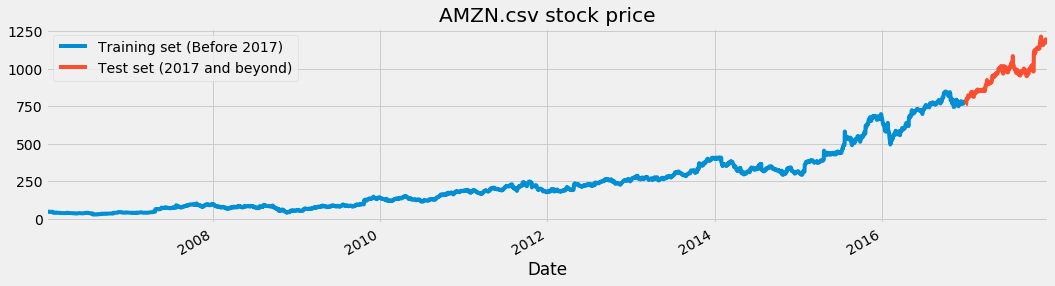

In [6]:
all_data = create_files_dict()
print(all_data)
for stock_name, stock_data in all_data.items():
    # initial plots
    plot_data(stock_data, stock_name)

    print('Preparing data')
    # create dl data
    X_train, y_train, X_test, sc = create_dl_train_test_split(stock_data)

    print('Single layer small RNN')
    # create small single layer small rnn preds
    small_single_layer_rnn, small_one_layer_preds = create_single_layer_small_rnn_model(
        X_train, y_train, X_test, sc)

    print('Single layer RNN')
    # create single layer rnn preds
    single_layer_rnn, one_layer_preds = create_single_layer_rnn_model(
        X_train, y_train, X_test, sc)

    print('Single RNN')
    # rnn daily preds
    rnn_model, rnn_preds = create_rnn_model(X_train, y_train, X_test, sc)

    print('GRU')
    # gru daily preds
    gru_model, gru_preds = create_GRU_model(X_train, y_train, X_test, sc)

    print('GRU with dropout')
    # gru daily preds
    gru_drop_model, gru_drop_preds = create_GRU_with_drop_out_model(
        X_train, y_train, X_test, sc)

    # yearly preds
#    yearly_preds = create_prophet_results(stock_data)

    # daily preds
    # prophet_daily_preds = create_prophet_daily_results(stock_data)



In [ ]:
# plot results
plot_results(stock_data,
             stock_name,
             small_one_layer_preds,
             one_layer_preds,
#             yearly_preds,
             gru_drop_preds,
             rnn_preds,
             gru_preds)




In [ ]:
gru_drop_preds

In [73]:
as_of_list.shape[1]

1

In [10]:
as_of_list = pd.read_pickle('../Crude Trading/AlexeysVersion/pickles/as_of_list_df')
#print(as_of_list)
for i in range(as_of_list.shape[0]):
    this_as_of = pd.to_datetime(as_of_list[0][i])
    print(this_as_of)
    x_train_df = pd.read_pickle('../Crude Trading/AlexeysVersion/pickles/x_train_' + str(this_as_of.month) +'_' + str(this_as_of.day) + '_' + str(this_as_of.year))
    x_trade_df = pd.read_pickle('../Crude Trading/AlexeysVersion/pickles/x_trade_' + str(this_as_of.month) +'_' + str(this_as_of.day) + '_' + str(this_as_of.year))
    y_train_df = pd.read_pickle('../Crude Trading/AlexeysVersion/pickles/y_train_' + str(this_as_of.month) +'_' + str(this_as_of.day) + '_' + str(this_as_of.year))
    probs_df = pd.read_pickle('../Crude Trading/AlexeysVersion/pickles/probs_' + str(this_as_of.month) +'_' + str(this_as_of.day) + '_' + str(this_as_of.year))

    x_train = x_train_df.values
    x_train = np.reshape(x_train_df.values, (x_train_df.shape[0], x_train_df.shape[1]))
    y_train = y_train_df.values

    print(x_train.shape)
    model = Sequential()
    model.add(SimpleRNN(6))
    model.add(Dense(1))
    
#     model = Sequential()
#     model.add(Dense(1, activation='sigmoid', input_dim=x_train.shape[1]))
#     model.compile(optimizer='rmsprop', loss='binary_crossentropy')

    # Set the input shape
    input_shape = (x_train_df.shape[1],)

    # Create the model
#     model = Sequential()
#     model.add(Dense(1, input_shape=input_shape, activation='relu'))
# #    model.add(Dense(2, activation='softmax'))
    
#     output_dim = nb_classes = 2 
#     model = Sequential() 
#     model.add(Dense(output_dim, input_dim=19, activation='softmax')) 

    model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    model.fit(x_train, y_train, epochs=nbr_epochs, batch_size=150, verbose = 0 )

    test_preds = model.predict(np.reshape(x_trade_df.values, (x_trade_df.shape[0], x_trade_df.shape[1], 1)))

    print(test_preds)
    print(probs_df)

                             0
0   2010-11-01 00:00:00.000000
1   2010-11-15 00:00:00.000000
2   2010-12-01 00:00:00.000000
3   2010-12-15 00:00:00.000000
4   2011-01-01 00:00:00.000000
..                         ...
230 2020-06-01 00:00:00.000000
231 2020-06-15 00:00:00.000000
232 2020-07-01 00:00:00.000000
233 2020-07-15 00:00:00.000000
234 2020-07-29 08:04:28.802182

[235 rows x 1 columns]
2010-11-01 00:00:00
(479, 19)


ValueError: Input 0 is incompatible with layer simple_rnn_3: expected ndim=3, found ndim=2

In [145]:
as_of_list.shape[0]

235

In [88]:
spreads = mk.getSeag([51],[1],['C+1','C+4'])

this_as_of:
2019-08-01 00:00:00
                   1        nn   c1c4
Date                                 
2019-08-01  0.909644  0.924466 -20.69
2019-08-02  0.911152  0.924088 -20.68
2019-08-05  0.896936  0.911572 -20.93
2019-08-06  0.880665  0.893083 -21.01
2019-08-07  0.871650  0.883976 -21.18
2019-08-08  0.814044  0.819738 -20.97
2019-08-09  0.812915  0.819292 -20.91
2019-08-12  0.781896  0.780553 -20.91
2019-08-13  0.757032  0.757202 -20.77
2019-08-14  0.710240  0.710580 -20.80
this_as_of:
2019-08-15 00:00:00


/anaconda3/envs/env3/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


                   1        nn   c1c4
Date                                 
2019-08-01  0.909644  0.924466 -20.69
2019-08-02  0.911152  0.924088 -20.68
2019-08-05  0.896936  0.911572 -20.93
2019-08-06  0.880665  0.893083 -21.01
2019-08-07  0.871650  0.883976 -21.18
2019-08-08  0.814044  0.819738 -20.97
2019-08-09  0.812915  0.819292 -20.91
2019-08-12  0.781896  0.780553 -20.91
2019-08-13  0.757032  0.757202 -20.77
2019-08-14  0.710240  0.710580 -20.80
2019-08-15  0.781083  0.791964 -20.77
2019-08-16  0.804244  0.814094 -20.67
2019-08-19  0.817996  0.827755 -20.59
2019-08-20  0.846434  0.860070 -20.59
2019-08-21  0.880620  0.896973 -20.53
2019-08-22  0.860733  0.879112 -20.50
2019-08-23  0.857416  0.873913 -20.39
2019-08-27  0.864857  0.881343 -20.41
2019-08-28  0.831675  0.847794 -20.26
2019-08-29  0.738709  0.738106 -20.21
2019-08-30  0.570053  0.535357 -20.16
this_as_of:
2019-09-01 00:00:00


/anaconda3/envs/env3/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


                   1        nn   c1c4
Date                                 
2019-08-01  0.909644  0.924466 -20.69
2019-08-02  0.911152  0.924088 -20.68
2019-08-05  0.896936  0.911572 -20.93
2019-08-06  0.880665  0.893083 -21.01
2019-08-07  0.871650  0.883976 -21.18
2019-08-08  0.814044  0.819738 -20.97
2019-08-09  0.812915  0.819292 -20.91
2019-08-12  0.781896  0.780553 -20.91
2019-08-13  0.757032  0.757202 -20.77
2019-08-14  0.710240  0.710580 -20.80
2019-08-15  0.781083  0.791964 -20.77
2019-08-16  0.804244  0.814094 -20.67
2019-08-19  0.817996  0.827755 -20.59
2019-08-20  0.846434  0.860070 -20.59
2019-08-21  0.880620  0.896973 -20.53
2019-08-22  0.860733  0.879112 -20.50
2019-08-23  0.857416  0.873913 -20.39
2019-08-27  0.864857  0.881343 -20.41
2019-08-28  0.831675  0.847794 -20.26
2019-08-29  0.738709  0.738106 -20.21
2019-08-30  0.570053  0.535357 -20.16
2019-09-02  0.273224  0.241085    NaN
2019-09-03  0.202387  0.174382 -20.19
2019-09-04  0.205860  0.179151 -20.12
2019-09-05  

/anaconda3/envs/env3/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


                   1        nn   c1c4
Date                                 
2019-08-01  0.909644  0.924466 -20.69
2019-08-02  0.911152  0.924088 -20.68
2019-08-05  0.896936  0.911572 -20.93
2019-08-06  0.880665  0.893083 -21.01
2019-08-07  0.871650  0.883976 -21.18
2019-08-08  0.814044  0.819738 -20.97
2019-08-09  0.812915  0.819292 -20.91
2019-08-12  0.781896  0.780553 -20.91
2019-08-13  0.757032  0.757202 -20.77
2019-08-14  0.710240  0.710580 -20.80
2019-08-15  0.781083  0.791964 -20.77
2019-08-16  0.804244  0.814094 -20.67
2019-08-19  0.817996  0.827755 -20.59
2019-08-20  0.846434  0.860070 -20.59
2019-08-21  0.880620  0.896973 -20.53
2019-08-22  0.860733  0.879112 -20.50
2019-08-23  0.857416  0.873913 -20.39
2019-08-27  0.864857  0.881343 -20.41
2019-08-28  0.831675  0.847794 -20.26
2019-08-29  0.738709  0.738106 -20.21
2019-08-30  0.570053  0.535357 -20.16
2019-09-02  0.273224  0.241085    NaN
2019-09-03  0.202387  0.174382 -20.19
2019-09-04  0.205860  0.179151 -20.12
2019-09-05  

/anaconda3/envs/env3/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


                   1        nn   c1c4
Date                                 
2019-08-01  0.909644  0.924466 -20.69
2019-08-02  0.911152  0.924088 -20.68
2019-08-05  0.896936  0.911572 -20.93
2019-08-06  0.880665  0.893083 -21.01
2019-08-07  0.871650  0.883976 -21.18
2019-08-08  0.814044  0.819738 -20.97
2019-08-09  0.812915  0.819292 -20.91
2019-08-12  0.781896  0.780553 -20.91
2019-08-13  0.757032  0.757202 -20.77
2019-08-14  0.710240  0.710580 -20.80
2019-08-15  0.781083  0.791964 -20.77
2019-08-16  0.804244  0.814094 -20.67
2019-08-19  0.817996  0.827755 -20.59
2019-08-20  0.846434  0.860070 -20.59
2019-08-21  0.880620  0.896973 -20.53
2019-08-22  0.860733  0.879112 -20.50
2019-08-23  0.857416  0.873913 -20.39
2019-08-27  0.864857  0.881343 -20.41
2019-08-28  0.831675  0.847794 -20.26
2019-08-29  0.738709  0.738106 -20.21
2019-08-30  0.570053  0.535357 -20.16
2019-09-02  0.273224  0.241085    NaN
2019-09-03  0.202387  0.174382 -20.19
2019-09-04  0.205860  0.179151 -20.12
2019-09-05  

/anaconda3/envs/env3/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


                   1        nn   c1c4
Date                                 
2019-08-01  0.909644  0.924466 -20.69
2019-08-02  0.911152  0.924088 -20.68
2019-08-05  0.896936  0.911572 -20.93
2019-08-06  0.880665  0.893083 -21.01
2019-08-07  0.871650  0.883976 -21.18
...              ...       ...    ...
2019-10-25  0.394363  0.332923 -19.33
2019-10-28  0.360697  0.319377 -19.35
2019-10-29  0.447535  0.411100 -19.28
2019-10-30  0.535689  0.513620 -19.12
2019-10-31  0.522186  0.486719 -19.07

[65 rows x 3 columns]
this_as_of:
2019-11-01 00:00:00


/anaconda3/envs/env3/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


                   1        nn   c1c4
Date                                 
2019-08-01  0.909644  0.924466 -20.69
2019-08-02  0.911152  0.924088 -20.68
2019-08-05  0.896936  0.911572 -20.93
2019-08-06  0.880665  0.893083 -21.01
2019-08-07  0.871650  0.883976 -21.18
...              ...       ...    ...
2019-11-08  0.748601  0.672022 -18.81
2019-11-11  0.723320  0.636330 -18.85
2019-11-12  0.758835  0.700692 -19.00
2019-11-13  0.753946  0.696462 -18.97
2019-11-14  0.685916  0.620114 -18.94

[75 rows x 3 columns]
this_as_of:
2019-11-15 00:00:00


/anaconda3/envs/env3/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


                   1        nn   c1c4
Date                                 
2019-08-01  0.909644  0.924466 -20.69
2019-08-02  0.911152  0.924088 -20.68
2019-08-05  0.896936  0.911572 -20.93
2019-08-06  0.880665  0.893083 -21.01
2019-08-07  0.871650  0.883976 -21.18
...              ...       ...    ...
2019-11-25  0.571423  0.499371 -18.82
2019-11-26  0.694350  0.653525 -18.78
2019-11-27  0.613465  0.563921 -18.75
2019-11-28  0.525984  0.444849    NaN
2019-11-29  0.516006  0.429781 -18.80

[86 rows x 3 columns]
this_as_of:
2019-12-01 00:00:00


/anaconda3/envs/env3/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


                   1        nn   c1c4
Date                                 
2019-08-01  0.909644  0.924466 -20.69
2019-08-02  0.911152  0.924088 -20.68
2019-08-05  0.896936  0.911572 -20.93
2019-08-06  0.880665  0.893083 -21.01
2019-08-07  0.871650  0.883976 -21.18
...              ...       ...    ...
2019-12-09  0.429384  0.326920 -18.38
2019-12-10  0.524081  0.430171 -18.48
2019-12-11  0.450464  0.361903 -18.45
2019-12-12  0.337682  0.246249 -18.41
2019-12-13  0.292153  0.210252 -18.31

[96 rows x 3 columns]
this_as_of:
2019-12-15 00:00:00


/anaconda3/envs/env3/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


KeyboardInterrupt: 

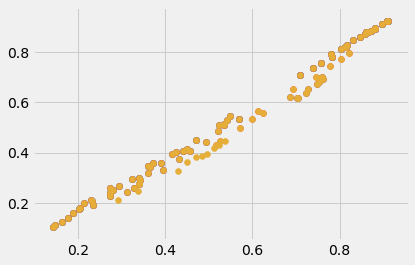

In [161]:

as_of_list = pd.read_pickle('../Crude Trading/AlexeysVersion/pickles/as_of_list_df')
#print(as_of_list)
flag = 0
for i in range(210,as_of_list.shape[0]):
    this_as_of = pd.to_datetime(as_of_list[0][i])
    print('this_as_of:',)
    print(this_as_of)
    x_train_df = pd.read_pickle('../Crude Trading/AlexeysVersion/pickles/x_train_' + str(this_as_of.month) +'_' + str(this_as_of.day) + '_' + str(this_as_of.year))
    x_trade_df = pd.read_pickle('../Crude Trading/AlexeysVersion/pickles/x_trade_' + str(this_as_of.month) +'_' + str(this_as_of.day) + '_' + str(this_as_of.year))
    y_train_df = pd.read_pickle('../Crude Trading/AlexeysVersion/pickles/y_train_' + str(this_as_of.month) +'_' + str(this_as_of.day) + '_' + str(this_as_of.year))
    probs_df = pd.read_pickle('../Crude Trading/AlexeysVersion/pickles/probs_' + str(this_as_of.month) +'_' + str(this_as_of.day) + '_' + str(this_as_of.year))


    x_train = x_train_df.values
    x_trade = x_trade_df.values

    #x_train = np.reshape(x_train_df.values, (x_train_df.shape[0], x_train_df.shape[1]))
    y_train = y_train_df.values


    
    input_layer = Input(shape=(x_train_df.shape[1],))
    dense_layer_1 = Dense(4, activation='sigmoid')(input_layer)
    #dense_layer_2 = Dense(2, activation='sigmoid')(dense_layer_1)
    #dense_layer_3 = Dense(25, activation='relu')(dense_layer_2)
    #output = Dense(1)(dense_layer_3)
    output = Dense(1, activation='sigmoid')(input_layer)
    #output = Dense(1, activation='sigmoid')(dense_layer_1)
    #output = Dense(1, activation='sigmoid')(dense_layer_2)




    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss="mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
    history = model.fit(x_train, y_train, batch_size=5, epochs=100, verbose=0)#, validation_split=0.2)
    pred_train = model.predict(x_train)
    #print(np.sqrt(mean_squared_error(y_train,pred_train)))

    trade_preds = model.predict(x_trade)
    #print(np.sqrt(mean_squared_error(y_test,pred)))

    
    
    if flag == 0:
        probs_df_list = np.array(probs_df[1].values)
        trade_preds_list = np.array(trade_preds)
        pnl_data = pd.DataFrame(probs_df[1], index=probs_df.index)
        pnl_data.loc[:,'nn'] = trade_preds_list
        pnl_data.loc[:,'c1c4'] = spreads.loc[:,'Value']
        print(pnl_data)
        flag = 1
    else:
        probs_df_list = np.concatenate((probs_df_list,probs_df[1].values))
        trade_preds_list = np.concatenate((trade_preds_list,trade_preds))
        pnl_data_aux = pd.DataFrame(probs_df[1], index=probs_df.index)
        pnl_data_aux.loc[:,'nn'] = trade_preds
        pnl_data_aux.loc[:,'c1c4'] = spreads.loc[:,'Value']
        pnl_data = pnl_data.append(pnl_data_aux)
        #print(pnl_data_aux)
        print(pnl_data)




    plt.scatter(probs_df_list,trade_preds_list)
    plt.show()
    #print(trade_preds)
    #print(probs_df)
    
    




In [ ]:
plt.plot(pnl_data[1])
plt.plot(pnl_data['nn'])

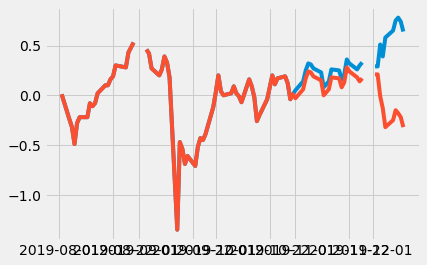

In [162]:
threshold = .5

pnl_data2 = pnl_data.copy()

pnl_data2.loc[pnl_data2[1]>=threshold,'logreg'] = 1
pnl_data2.loc[pnl_data2[1]<1-threshold,'logreg'] = -1
pnl_data2.loc[pnl_data2['nn']>=threshold,'nnpos'] = 1
pnl_data2.loc[pnl_data2['nn']<1-threshold,'nnpos'] = -1

pnl_data2['logreg pnl'] = pnl_data2['logreg'].shift(1)*(pnl_data2['c1c4']-pnl_data2['c1c4'].shift(1))
pnl_data2['nn pnl'] = pnl_data2['nnpos'].shift(1)*(pnl_data2['c1c4']-pnl_data2['c1c4'].shift(1))

plt.plot(pnl_data2['logreg pnl'].cumsum())
plt.plot(pnl_data2['nn pnl'].cumsum())

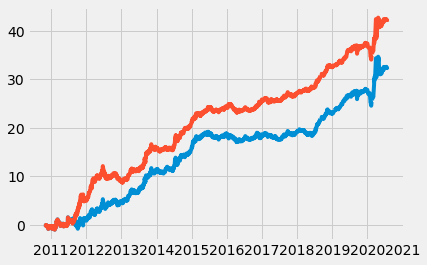

In [152]:
threshold = .5

pnl_data2 = pnl_data.copy()

pnl_data2.loc[pnl_data2[1]>=threshold,'logreg'] = 1
pnl_data2.loc[pnl_data2[1]<1-threshold,'logreg'] = -1
pnl_data2.loc[pnl_data2['nn']>=threshold,'nnpos'] = 1
pnl_data2.loc[pnl_data2['nn']<1-threshold,'nnpos'] = -1

pnl_data2['logreg pnl'] = pnl_data2['logreg'].shift(1)*(pnl_data2['c1c4']-pnl_data2['c1c4'].shift(1))
pnl_data2['nn pnl'] = pnl_data2['nnpos'].shift(1)*(pnl_data2['c1c4']-pnl_data2['c1c4'].shift(1))

plt.plot(pnl_data2['logreg pnl'].cumsum())
plt.plot(pnl_data2['nn pnl'].cumsum())

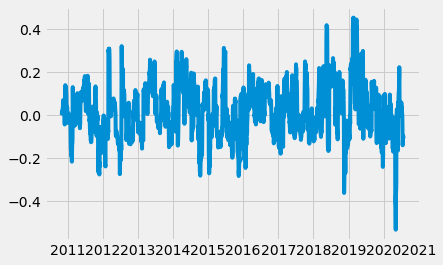

In [153]:
plt.plot(pnl_data2[1]-pnl_data2['nn'])


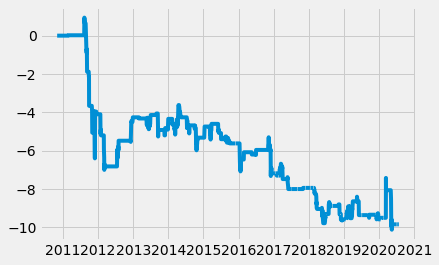

In [154]:
plt.plot(pnl_data2['logreg pnl'].cumsum()-pnl_data2['nn pnl'].cumsum())



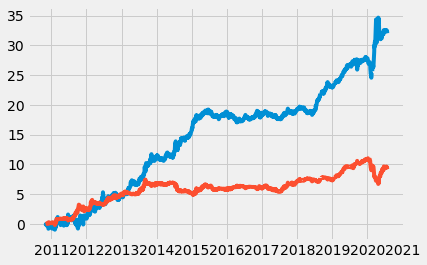

/anaconda3/envs/env3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


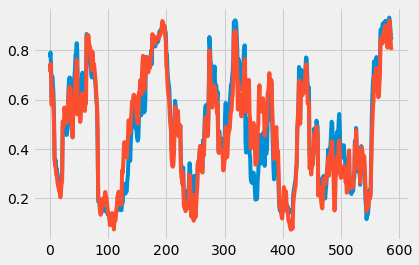

In [83]:
plt.plot(trade_preds_list)
plt.plot(probs_df_list)
plt.show()